In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import utils.visualisations
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms

import utils.metrics
import utils.model

import models.mnist
import models.resnet
import models.resnet_dropout
from torchensemble import VotingClassifier

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [15]:
from datasets.transforms import AddGaussianNoise

transforms_train = torchvision.transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
            ])

transforms_test = torchvision.transforms.Compose(
    [
        # transforms.RandomRotation(degrees=(25, 25)),
        # transforms.ColorJitter(brightness=.5, saturation=1, contrast=1),

        transforms.ToTensor(),
        # AddGaussianNoise(mean=0, std=.10),

        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

data_train = torchvision.datasets.CIFAR100(
    "cifar100", download=True, train=True, transform=transforms_train)
data_train, data_val = torch.utils.data.random_split(data_train, [45000, 5000], generator=torch.Generator().manual_seed(0))

data_loader_train = torch.utils.data.DataLoader(data_train,
                                                batch_size=64,
                                                shuffle=True,
                                                )
data_loader_val = torch.utils.data.DataLoader(data_val,
                                                batch_size=64,
                                                shuffle=False,
                                                )

data_test = torchvision.datasets.CIFAR100(
    "cifar100", download=True, train=False, transform=transforms_test)
data_loader_test = torch.utils.data.DataLoader(data_test,
                                               batch_size=64,
                                               shuffle=False)

data_test_unnormalized = torchvision.datasets.CIFAR100(
    "cifar100", download=True, train=False, transform= torchvision.transforms.Compose(
    [
        # transforms.RandomRotation(degrees=(25, 25)),
        # transforms.ColorJitter(brightness=.5, saturation=1, contrast=1),
        # torchvision.transforms.GaussianBlur(5,0.8),
        transforms.ToTensor(),
        AddGaussianNoise(mean=0, std=0.05),

        # transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ]))

dataset_sizes = {"train": len(data_train), "val": len(data_val), "test": len(data_test)}
data_loaders = {"train": data_loader_train, "val": data_loader_val, "test": data_loader_test}

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


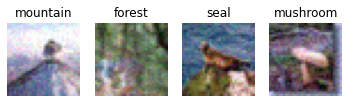

In [16]:
num = 4
fig, axs = plt.subplots(1, num)

for i in range(num):
    axs[i].imshow(data_test_unnormalized[i][0].permute(1,2,0))
    axs[i].set_title(
        f"{class_names[int(data_test_unnormalized[i][1])]}"
    )
    axs[i].axis("off")

plt.savefig("figures/cifar100-gaussian-noise-examples.pdf")

In [5]:
from torchensemble.utils import io
model = models.resnet.ResNet18(
    num_classes=100).to(device)
ensemble = VotingClassifier(estimator=model, n_estimators=5)

state = torch.load("checkpoints/VotingClassifier_ResNet_5_ckpt.pth")
n_estimators = state["n_estimators"]
model_params = state["model"]

# Pre-allocate and load all base estimators
for _ in range(n_estimators):
    ensemble.estimators_.append(ensemble._make_estimator())
ensemble.load_state_dict(model_params)


<All keys matched successfully>

In [6]:
# model = torch.load("checkpoints/cifar100_resnet18.pt", map_location=device)
# model_dropout = torch.load("checkpoints/cifar100_resnet18_dropout.pt", map_location=device)

model = torch.load("checkpoints/cifar100_resnet18.pt")
model_dropout = torch.load("checkpoints/cifar100_resnet18_dropout0.1.pt")
model_dropout.load_state_dict(model.state_dict())
model = model_dropout
model.dropout = torch.nn.Dropout(p=0)

model_dropout = torch.load("checkpoints/cifar100_resnet18_dropout0.1.pt")
model_dropout.dropout = torch.nn.Dropout(p=0)

model_finetuned = model
weights = torch.load("checkpoints/cifar100_resnet18.pt")
model = torch.load("checkpoints/cifar100_resnet18_dropout0.1.pt")
model.load_state_dict(weights.state_dict())
utils.mc_dropout.set_dropout_p(model, model, .03)
model.dropout = torch.nn.Dropout(p=0)


# model_dropout = torch.load("models/cifar100_resnet18_0.2dropout_all")
# utils.mc_dropout.set_dropout_p(model_dropout, model_dropout, .15)
# model_dropout.dropout = torch.nn.Dropout(p=0)

In [47]:
model = torch.load("checkpoints/cifar100_mobilenetv2.pt")
model_dropout = torch.load("checkpoints/cifar100_mobilenetv2_dropout0.1.pt")
model_dropout.load_state_dict(model.state_dict())
model = model_dropout
# utils.mc_dropout.set_dropout_p(model, model, .03)
model.dropout = torch.nn.Dropout(p=0)

model_dropout = torch.load("checkpoints/cifar100_mobilenetv2_dropout0.1.pt")
model_dropout.dropout = torch.nn.Dropout(p=0)

model_finetuned = model
weights = torch.load("checkpoints/cifar100_mobilenetv2.pt")
model = torch.load("checkpoints/cifar100_mobilenetv2_dropout0.1.pt")
model.load_state_dict(weights.state_dict())
utils.mc_dropout.set_dropout_p(model, model, .03)
model.dropout = torch.nn.Dropout(p=0)

In [49]:
model

MobileNetV2Dropout(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidualDropout(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout2d(p=0.03, inplace=False)
      )
    )
    (2): InvertedResidualDropout(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False

In [35]:
model.classifier[0] = nn.Dropout(p=0.5)

In [28]:
utils.mc_dropout.set_dropout_p(model_dropout, model_dropout, 0.1)

ResNetDropout(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (dropout): Dropout2d(p=0.1, inplace=False)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

In [50]:
# model = models.resnet_dropout.ResNet18Dropout(num_classes=100).to(device)
print(model)
optimizer = torch.optim.Adam(model_finetuned.parameters())
criterion = nn.CrossEntropyLoss()
train_progress = utils.model.train_model(
    model_finetuned, 10, optimizer, criterion, data_loaders, device)

MobileNetV2Dropout(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidualDropout(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout2d(p=0.03, inplace=False)
      )
    )
    (2): InvertedResidualDropout(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False

train Loss: 1.76 Acc: 0.51 Avg. conf: 0.64 Avg. max. prob: 0.53: 100%|██████████| 704/704 [00:41<00:00, 16.99it/s]
val Loss: 1.61 Acc: 0.56 Avg. conf: 0.70 Avg. max. prob: 0.60: 100%|██████████| 79/79 [00:02<00:00, 37.81it/s]

Epoch 2/10
----------



train Loss: 1.63 Acc: 0.54 Avg. conf: 0.65 Avg. max. prob: 0.54: 100%|██████████| 704/704 [00:35<00:00, 19.63it/s]
val Loss: 1.58 Acc: 0.56 Avg. conf: 0.71 Avg. max. prob: 0.60: 100%|██████████| 79/79 [00:01<00:00, 39.56it/s]

Epoch 3/10
----------



train Loss: 1.58 Acc: 0.54 Avg. conf: 0.66 Avg. max. prob: 0.55: 100%|██████████| 704/704 [00:35<00:00, 19.56it/s]
val Loss: 1.58 Acc: 0.57 Avg. conf: 0.72 Avg. max. prob: 0.62: 100%|██████████| 79/79 [00:02<00:00, 39.09it/s]

Epoch 4/10
----------



train Loss: 1.55 Acc: 0.55 Avg. conf: 0.67 Avg. max. prob: 0.56: 100%|██████████| 704/704 [00:35<00:00, 19.68it/s]
val Loss: 1.54 Acc: 0.57 Avg. conf: 0.71 Avg. max. prob: 0.60: 100%|██████████| 79/79 [00:01<00:00, 39.91it/s]

Epoch 5/10
----------



train Loss: 1.52 Acc: 0.56 Avg. conf: 0.67 Avg. max. prob: 0.56: 100%|██████████| 704/704 [00:35<00:00, 19.70it/s]
val Loss: 1.59 Acc: 0.56 Avg. conf: 0.72 Avg. max. prob: 0.62: 100%|██████████| 79/79 [00:01<00:00, 39.69it/s]

Epoch 6/10
----------



train Loss: 1.49 Acc: 0.57 Avg. conf: 0.68 Avg. max. prob: 0.57: 100%|██████████| 704/704 [00:35<00:00, 19.73it/s]
val Loss: 1.59 Acc: 0.57 Avg. conf: 0.72 Avg. max. prob: 0.62: 100%|██████████| 79/79 [00:02<00:00, 38.90it/s]

Epoch 7/10
----------



train Loss: 1.50 Acc: 0.57 Avg. conf: 0.68 Avg. max. prob: 0.57: 100%|██████████| 704/704 [00:35<00:00, 19.66it/s]
val Loss: 1.56 Acc: 0.57 Avg. conf: 0.72 Avg. max. prob: 0.62: 100%|██████████| 79/79 [00:02<00:00, 39.27it/s]

Epoch 8/10
----------



train Loss: 1.47 Acc: 0.58 Avg. conf: 0.68 Avg. max. prob: 0.58: 100%|██████████| 704/704 [00:35<00:00, 19.62it/s]
val Loss: 1.53 Acc: 0.57 Avg. conf: 0.72 Avg. max. prob: 0.62: 100%|██████████| 79/79 [00:02<00:00, 39.03it/s]

Epoch 9/10
----------



train Loss: 1.44 Acc: 0.58 Avg. conf: 0.69 Avg. max. prob: 0.58: 100%|██████████| 704/704 [00:35<00:00, 19.64it/s]
val Loss: 1.55 Acc: 0.57 Avg. conf: 0.73 Avg. max. prob: 0.63: 100%|██████████| 79/79 [00:02<00:00, 39.22it/s]

Epoch 10/10
----------



train Loss: 1.43 Acc: 0.58 Avg. conf: 0.69 Avg. max. prob: 0.59: 100%|██████████| 704/704 [00:35<00:00, 19.66it/s]
val Loss: 1.53 Acc: 0.58 Avg. conf: 0.73 Avg. max. prob: 0.62: 100%|██████████| 79/79 [00:02<00:00, 38.89it/s]


In [51]:
from utils.temperature_scaling import ModelWithTemperature
scaled_model = ModelWithTemperature(model, device)
scaled_model.set_temperature(data_loader_val)

# scaled_model_dropout = ModelWithTemperature(model_dropout, device)
# scaled_model_dropout.set_temperature(data_loader_val)

Before temperature - NLL: 1.876, ECE: 0.114
Optimal temperature: 1.454
After temperature - NLL: 1.757, ECE: 0.024


ModelWithTemperature(
  (model): MobileNetV2Dropout(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidualDropout(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Dropout2d(p=0.03, inplace=False)
        )
      )
      (2): InvertedResidualDropout(
        (conv): Sequential(
          (0): ConvBNReLU(


In [52]:

progress_ensemble = utils.model.run_validation(
    ensemble, data_loaders["test"], utils.metrics.Progress(), device, mc_dropout_iters=0)
progress_model = utils.model.run_validation(
    model, data_loaders["test"], utils.metrics.Progress(), device, mc_dropout_iters=20)
progress_model_finetuned = utils.model.run_validation(
    model_finetuned, data_loaders["test"], utils.metrics.Progress(), device, mc_dropout_iters=20)
progress_model_dropout = utils.model.run_validation(
    model_dropout, data_loaders["test"], utils.metrics.Progress(), device, mc_dropout_iters=20)
progress_scaled_model = utils.model.run_validation(
    scaled_model, data_loaders["test"], utils.metrics.Progress(), device, mc_dropout_iters=0)


Avg. acc.: 59.32: 100%|██████████| 157/157 [00:03<00:00, 48.77it/s]


In [4]:
import pickle
with open("cifar100/cifar-100-python/meta", "rb") as f:
    meta = pickle.load(f)

In [5]:
class_names = list(meta.values())[0]

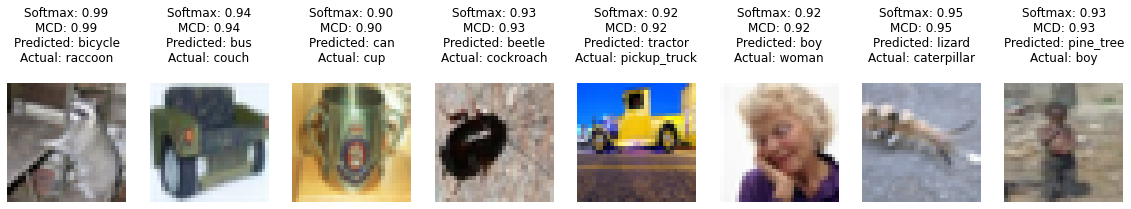

In [12]:
incorrect = np.argwhere((progress_model.predictions != progress_model.labels) & (progress_model.max_probs > .9)).ravel()
# idx = np.argsort(progress_model.max_probs)[::-1][incorrect]
idx=incorrect
num = 8
fig, axs = plt.subplots(1, num, figsize=(20,10))
dropout_max_probs_untrained = progress_model.dropout_outputs.max(axis=-1)

for i in range(num):
    axs[i].imshow(data_test_unnormalized[idx[i]][0].permute(1,2,0), cmap="Greys")
    axs[i].set_title(
        f"Softmax: {progress_model.max_probs[idx[i]]:.2f}\n"
        f"MCD: {dropout_max_probs_untrained[idx[i]]:.2f}\n"
        f"Predicted: {class_names[int(progress_model.predictions[idx[i]])]}\n"
        f"Actual: {class_names[int(progress_model.labels[idx[i]])]}\n"
    )
    axs[i].axis("off")


# progress_model.max_probs[ids]


In [34]:
model_finetuned

ResNetDropout(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (dropout): Dropout2d(p=0.1, inplace=False)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

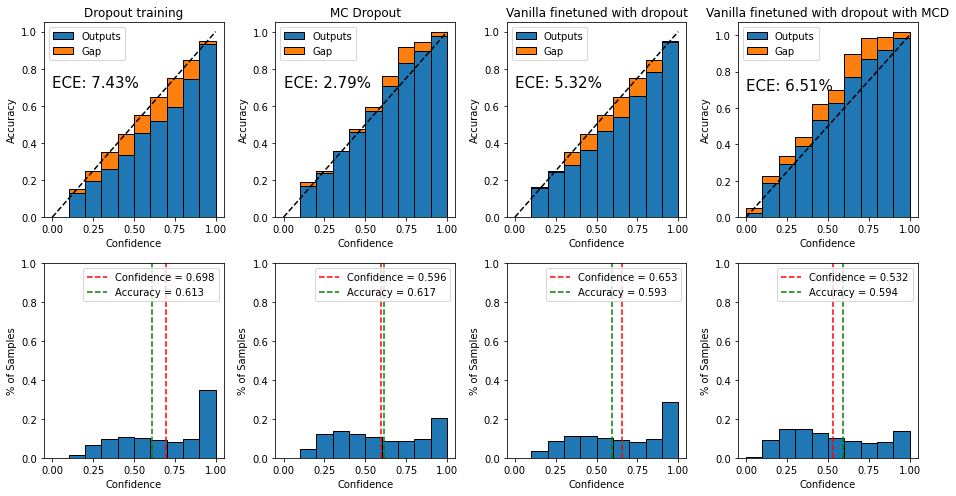

In [54]:
dropout_finetuned_max_probs = progress_model_finetuned.dropout_outputs.max(axis=-1)
dropout_max_probs = progress_model.dropout_outputs.max(axis=-1)
trained_dropout_max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)
# dropout_scaled_max_probs = progress_scaled_model_dropout.dropout_outputs.max(axis=-1)


ensemble_max_probs = progress_ensemble.logits.max(axis=1)
utils.visualisations.calibration_graph([
        # ("Vanilla", progress_model.max_probs, np.argsort(progress_model.max_probs), progress_model.predictions),
        # ("Dropout inference", dropout_max_probs, np.argsort(dropout_max_probs), progress_model.dropout_predictions),
        # ("Temperature scaling", progress_scaled_model.max_probs, np.argsort(progress_scaled_model.max_probs), progress_scaled_model.predictions),
        # ("Ensemble", ensemble_max_probs, np.argsort(ensemble_max_probs), progress_ensemble.predictions),

        ("Dropout training", progress_model_dropout.max_probs, np.argsort(progress_model.max_probs), progress_model_dropout.predictions),
        ("MC Dropout", trained_dropout_max_probs, np.argsort(trained_dropout_max_probs), progress_model_dropout.dropout_predictions),

        ("Vanilla finetuned with dropout", progress_model_finetuned.max_probs, np.argsort(progress_model_finetuned.max_probs), progress_model_finetuned.predictions),
        ("Vanilla finetuned with dropout with MCD", dropout_finetuned_max_probs, np.argsort(dropout_finetuned_max_probs), progress_model_finetuned.dropout_predictions),
    ],
    progress_model.labels,
    figsize=(13,7)
    )

plt.savefig("figures/cifar100-mobilenetv2-calibration2.pdf")

In [18]:
y_true = nn.functional.one_hot(torch.tensor(progress_model.labels.astype("long")))

print("Brier score")
print("Ensemble: " + str(utils.metrics.compute_brier_score_avg(progress_ensemble.logits, y_true)))
print("MC Dropout: " + str(utils.metrics.compute_brier_score_avg(progress_model.dropout_outputs, y_true)))
print("Baseline: " + str(utils.metrics.compute_brier_score_avg(progress_model.probs, y_true)))
print("Baseline trained with dropout: " + str(utils.metrics.compute_brier_score_avg(progress_model_dropout.probs, y_true)))
print("MC Dropout - trained: " + str(utils.metrics.compute_brier_score_avg(progress_model_dropout.dropout_outputs, y_true)))
print("Temperature scaling: " + str(utils.metrics.compute_brier_score_avg(progress_scaled_model.probs, y_true)))

Brier score
Ensemble: 0.003734451324129658
MC Dropout: 0.004741831274326375
Baseline: 0.00553298274156638
Baseline trained with dropout: 0.005241850545741098
MC Dropout - trained: 0.0047262803315466844
Temperature scaling: 0.004930029249480763


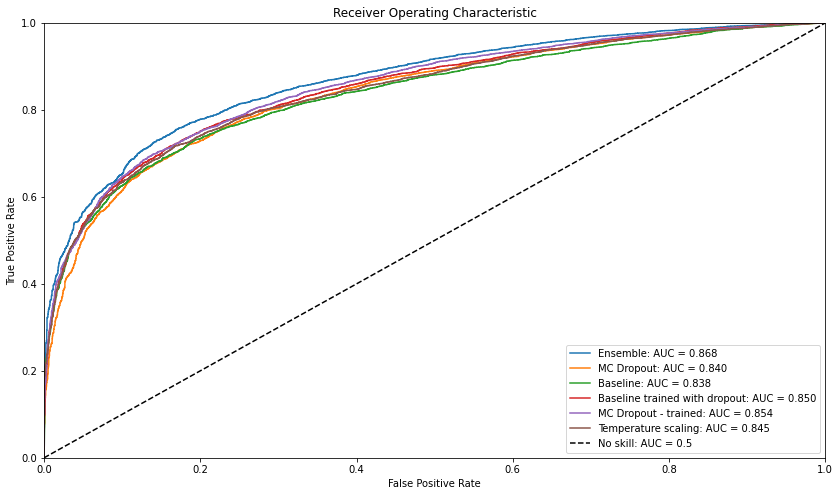

In [19]:
curves = []


correct = progress_ensemble.predictions == progress_ensemble.labels
max_probs = progress_ensemble.logits.max(axis=-1)
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "Ensemble"))

correct = progress_model.dropout_predictions == progress_model.labels
max_probs = progress_model.dropout_outputs.max(axis=-1)
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "MC Dropout"))

correct = progress_model.predictions == progress_model.labels
max_probs = progress_model.max_probs
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "Baseline"))

correct = progress_model_dropout.predictions == progress_model.labels
max_probs = progress_model_dropout.max_probs
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "Baseline trained with dropout"))

correct = progress_model_dropout.dropout_predictions == progress_model.labels
max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "MC Dropout - trained"))

correct = progress_scaled_model.predictions == progress_scaled_model.labels
max_probs = progress_scaled_model.max_probs
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "Temperature scaling"))



plt.figure(figsize=(14,8))
plt.title('Receiver Operating Characteristic')
for curve in curves:
    plt.plot(curve["fpr"], curve["tpr"], label = f"{curve['label']}: AUC = {curve['auroc']:.3f}" )
plt.plot([0, 1], [0, 1],'k--', label=f"No skill: AUC = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

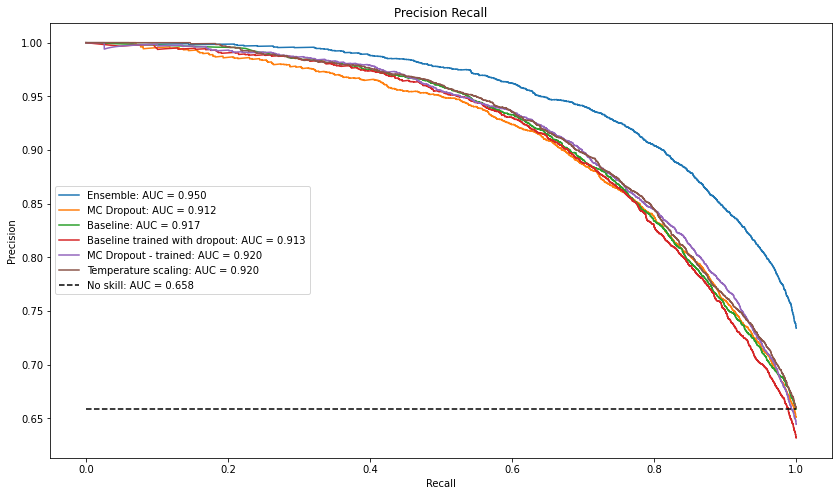

In [20]:
no_skill = correct.sum() / len(correct)
plt.figure(figsize=(14,8))
plt.title('Precision Recall')
for curve in curves:
    plt.plot(curve["recall"], curve["prec"], label=f"{curve['label']}: AUC = {curve['aupr']:.3f}")
# axis labels
plt.plot([0, 1], [no_skill, no_skill], color="k", linestyle='--', label=f'No skill: AUC = {no_skill:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [78]:
curves = {
    "Vanilla": utils.metrics.model_metrics(),
    "Dropout inference": utils.metrics.model_metrics(),
    "Temperature scaling":utils.metrics.model_metrics(),
    "Dropout training": utils.metrics.model_metrics(),
    "MC Dropout":utils.metrics.model_metrics(),

    "Ensemble": utils.metrics.model_metrics(),
    "Vanilla finetuned with dropout":utils.metrics.model_metrics(),
    "Vanilla finetuned with dropout with MCD":utils.metrics.model_metrics(),
}

from datasets.transforms import AddGaussianNoise


for s in np.arange(0, 0.6, 0.05):
    transforms_test = torchvision.transforms.Compose(
        [
            # transforms.RandomRotation(degrees=(s,s)),
            # transforms.ColorJitter(brightness=s/2, saturation=s, contrast=s),
            # torchvision.transforms.GaussianBlur(5,s),
            transforms.ToTensor(),
            AddGaussianNoise(mean=0, std=s),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])

    data_test = torchvision.datasets.CIFAR100(
        "cifar100", download=True, train=False, transform=transforms_test)
    data_loader_test = torch.utils.data.DataLoader(data_test,
                                                batch_size=64,
                                                shuffle=False)
    

    print(f"Strength: {s}")
    progress_ensemble = utils.model.run_validation(
        ensemble, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=0)
    progress_model = utils.model.run_validation(
        model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=20)
    progress_model_dropout = utils.model.run_validation(
        model_dropout, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=20)
    progress_scaled_model = utils.model.run_validation(
        scaled_model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=0)
    progress_model_finetuned = utils.model.run_validation(
        model_finetuned, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=20)


    # dropout_max_probs = progress_model.dropout_outputs.max(axis=-1)
    # trained_dropout_max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)

    bins = np.linspace(0.05, 0.95, num=10)
    labels = progress_model.labels


    max_probs = progress_ensemble.logits.max(axis=1)
    utils.metrics.update_model_metrics(progress_ensemble, progress_ensemble.logits, max_probs, progress_ensemble.predictions, labels, bins, curves["Ensemble"], s)

    max_probs = progress_model.dropout_outputs.max(axis=-1)
    utils.metrics.update_model_metrics(progress_model, progress_model.dropout_outputs, max_probs, progress_model.dropout_predictions, labels, bins, curves["Dropout inference"], s)
    
    max_probs = progress_model.max_probs
    utils.metrics.update_model_metrics(progress_model, progress_model.probs, max_probs, progress_model.predictions, labels, bins, curves["Vanilla"], s)

    max_probs = progress_model_dropout.max_probs
    utils.metrics.update_model_metrics(progress_model_dropout, progress_model_dropout.probs, max_probs, progress_model_dropout.predictions, labels, bins, curves["Dropout training"], s)

    max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)
    utils.metrics.update_model_metrics(progress_model_dropout, progress_model_dropout.dropout_outputs, max_probs, progress_model_dropout.dropout_predictions, labels, bins, curves["MC Dropout"], s)

    max_probs = progress_scaled_model.max_probs
    utils.metrics.update_model_metrics(progress_scaled_model, progress_scaled_model.probs, max_probs, progress_scaled_model.predictions, labels, bins, curves["Temperature scaling"], s)
    
    max_probs = progress_model_finetuned.max_probs
    utils.metrics.update_model_metrics(progress_model_finetuned, progress_model_finetuned.probs, max_probs, progress_model_finetuned.predictions, labels, bins, curves["Vanilla finetuned with dropout"], s)

    max_probs = progress_model_finetuned.dropout_outputs.max(axis=-1)
    utils.metrics.update_model_metrics(progress_model_finetuned, progress_model_finetuned.dropout_outputs, max_probs, progress_model_finetuned.dropout_predictions, labels, bins, curves["Vanilla finetuned with dropout with MCD"], s)

Files already downloaded and verified
Strength: 0.0


Avg. acc.: 59.29: 100%|██████████| 157/157 [00:23<00:00,  6.77it/s]


Files already downloaded and verified
Strength: 0.05


Avg. acc.: 25.46: 100%|██████████| 157/157 [00:23<00:00,  6.74it/s]


Files already downloaded and verified
Strength: 0.1


Avg. acc.: 8.82: 100%|██████████| 157/157 [00:23<00:00,  6.80it/s]


Files already downloaded and verified
Strength: 0.15000000000000002


Avg. acc.: 4.82: 100%|██████████| 157/157 [00:23<00:00,  6.75it/s]


Files already downloaded and verified
Strength: 0.2


Avg. acc.: 3.40: 100%|██████████| 157/157 [00:23<00:00,  6.78it/s]


Files already downloaded and verified
Strength: 0.25


Avg. acc.: 2.88: 100%|██████████| 157/157 [00:23<00:00,  6.76it/s]


Files already downloaded and verified
Strength: 0.30000000000000004


Avg. acc.: 2.65: 100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


Files already downloaded and verified
Strength: 0.35000000000000003


Avg. acc.: 2.47: 100%|██████████| 157/157 [00:23<00:00,  6.76it/s]


Files already downloaded and verified
Strength: 0.4


Avg. acc.: 2.21: 100%|██████████| 157/157 [00:23<00:00,  6.77it/s]


Files already downloaded and verified
Strength: 0.45


Avg. acc.: 2.02: 100%|██████████| 157/157 [00:23<00:00,  6.81it/s]


Files already downloaded and verified
Strength: 0.5


Avg. acc.: 1.82: 100%|██████████| 157/157 [00:23<00:00,  6.80it/s]


Files already downloaded and verified
Strength: 0.55


Avg. acc.: 1.74: 100%|██████████| 157/157 [00:23<00:00,  6.74it/s]


In [79]:
import pickle
with open("experiments/cifar100_mobilenetv2_gaussian_noise.pickle", "wb") as f:
    pickle.dump(curves,f)

In [73]:
import pickle
with open("experiments/cifar100_resnet18_gaussian_noise.pickle", "rb") as f:
    curves = pickle.load(f)

In [74]:
len(curves["Vanilla"].acc), curves["Vanilla"].strengths

(12,
 [0.0,
  0.05,
  0.1,
  0.15000000000000002,
  0.2,
  0.25,
  0.30000000000000004,
  0.35000000000000003,
  0.4,
  0.45,
  0.5,
  0.55])

In [60]:
new_curves = {}
new_curves["Vanilla"] = curves["Vanilla"]
new_curves["Dropout inference"] = curves["Dropout inference"]
new_curves["Temperature scaling"] = curves["Temperature scaling"]
new_curves["Dropout training"] = curves["Dropout training"]
new_curves["MC Dropout"] = curves["MC Dropout"]
new_curves["Ensemble"] = curves["Ensemble"]
new_curves["Vanilla finetuned with dropout"] = curves["Vanilla finetuned with dropout"]
new_curves["Vanilla finetuned with dropout with MCD"] = curves["Vanilla finetuned with dropout"]


curves = new_curves


In [33]:
curves = new_curves

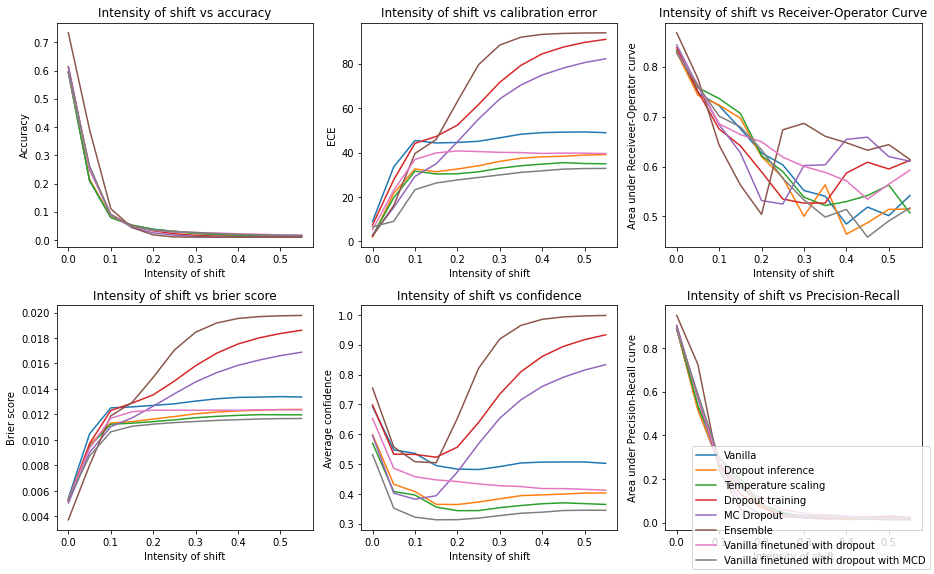

In [80]:
fig, axs = plt.subplots(2, 3, figsize=(13, 8))
for name, m in curves.items():
    ax = axs[0][0]
    ax.plot(m.strengths, m.acc, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs accuracy")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Accuracy")

    ax = axs[1][0]
    ax.plot(m.strengths, m.brier, label=name)
    ax.set_title("Intensity of shift vs brier score")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Brier score")

    ax = axs[0][1]
    ax.plot(m.strengths, m.ece, label=name)
    ax.set_title("Intensity of shift vs calibration error")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("ECE")

    ax = axs[1][1]
    ax.plot(m.strengths, m.confs, label=name)
    ax.set_title("Intensity of shift vs confidence")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Average confidence")

    ax = axs[0][2]
    ax.plot(m.strengths, m.auroc, label=name)
    ax.set_title("Intensity of shift vs Receiver-Operator Curve")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Area under Receiveer-Operator curve")

    ax = axs[1][2]
    ax.plot(m.strengths, m.aupr, label=name)
    ax.set_title("Intensity of shift vs Precision-Recall")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Area under Precision-Recall curve")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')
fig.tight_layout()

plt.savefig("figures/cifar-mobilenetv2-gaussian-noise.pdf")